In [2]:
## Add path to sys
import sys
sys.path.append('../../')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from preprocessing import data_processing
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
train_dataset = 'D:/Projects/tumai_braintumor_classification/dataset/train/'
test_dataset = 'D:/Projects/tumai_braintumor_classification/dataset/test/'
IMG_SIZE = (224,224)

X_train, y_train, labels = data_processing.load_data_tonumpy(train_dataset, IMG_SIZE)
X_test, y_test, _ = data_processing.load_data_tonumpy(test_dataset, IMG_SIZE)


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]


202 images loaded from D:/Projects/tumai_braintumor_classification/dataset/train/ directory.


100%|██████████| 2/2 [00:00<00:00, 12.50it/s]

51 images loaded from D:/Projects/tumai_braintumor_classification/dataset/test/ directory.


In [4]:
# apply this for each set
X_train_crop = data_processing.crop_imgs(set_name=X_train)
X_test_crop = data_processing.crop_imgs(set_name=X_test)

### Preprocessing for VGG

In [5]:
from keras.applications.vgg16 import VGG16
from keras import layers
from keras.applications.vgg16 import preprocess_input
from keras.models import Model, Sequential
from matplotlib import pyplot 
from numpy import expand_dims

In [6]:
def preprocess_for_vgg(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        # set_new.append(preprocess_input(img))
        set_new.append(img/255)
    return np.array(set_new)

In [7]:
X_train_prep = preprocess_for_vgg(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_for_vgg(set_name=X_test_crop, img_size=IMG_SIZE)

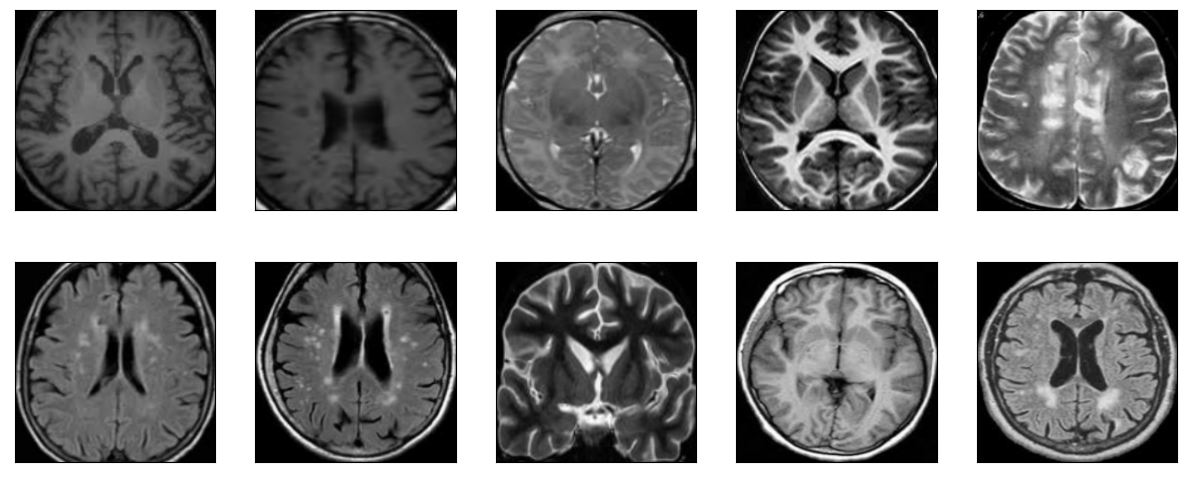

In [8]:
## Plot 10 images from X_train_crop
plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train_prep[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

## VGG with GALA

In [42]:
def GALA(inputs):

    global_map = layers.Convolution2D(inputs.shape[-1], (inputs.shape[1], inputs.shape[2]), activation='sigmoid')(inputs)
    # global_map = layers.GlobalAveragePooling2D()(inputs)

    ## Use squeze and excitation
    # global_map = layers.GlobalAveragePooling2D()(inputs)
    # global_map = layers.Reshape((1,1,inputs.shape[-1]))(global_map)
    # global_map = layers.Dense(inputs.shape[-1], activation='sigmoid')(global_map)


    local_map = layers.Convolution2D(1, (1,1), activation='sigmoid')(inputs)

    ## Multiply 
    return layers.Multiply()([global_map, local_map])


In [43]:
## Make a VGG16 model and freeze the layers and add a head 
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16.trainable = False

## Add a head
head = vgg16.output
head = GALA(head)
head = layers.Flatten()(head)
head = layers.Dense(512, activation='relu')(head)
head = layers.Dropout(0.5)(head)
head = layers.Dense(1, activation='sigmoid')(head)

## Make a model
model = Model(inputs=vgg16.input, outputs=head)

## Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [45]:
## Early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    # monitor='val_loss',
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

model.fit(
    X_train_prep,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_prep, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100
7/7 [==============================] - 25s 4s/step - loss: 0.1782 - accuracy: 0.9752 - val_loss: 0.3080 - val_accuracy: 0.9020
Epoch 2/100
7/7 [==============================] - 25s 4s/step - loss: 0.1235 - accuracy: 0.9901 - val_loss: 0.2666 - val_accuracy: 0.9216
Epoch 3/100
7/7 [==============================] - 25s 4s/step - loss: 0.0987 - accuracy: 0.9901 - val_loss: 0.2369 - val_accuracy: 0.9216
Epoch 4/100
7/7 [==============================] - 26s 4s/step - loss: 0.0692 - accuracy: 0.9950 - val_loss: 0.3073 - val_accuracy: 0.9020
Epoch 5/100
7/7 [==============================] - 26s 4s/step - loss: 0.0627 - accuracy: 0.9851 - val_loss: 0.2238 - val_accuracy: 0.9020
Epoch 5: early stopping


In [46]:
model.evaluate(X_test_prep, y_test)

2/2 [==============================] - 4s 2s/step - loss: 0.2666 - accuracy: 0.9216


[0.26662832498550415, 0.9215686321258545]

## Checking the model

In [47]:
from sklearn.metrics import f1_score, confusion_matrix

y_pred = model.predict(X_test_prep)
y_pred = np.where(y_pred > 0.5, 1, 0)

f1_score(y_test, y_pred)
confusion_matrix(y_test, y_pred)

2/2 [==============================] - 4s 2s/step


array([[16,  4],
       [ 0, 31]], dtype=int64)

In [48]:
## Get all X_test and y_test with wrong prediction

X_test_wrong = X_test_prep[y_test != y_pred.reshape(-1)]
y_test_wrong = y_test[y_test != y_pred.reshape(-1)]

X_test_right = X_test_prep[y_test == y_pred.reshape(-1)]
y_test_right = y_test[y_test == y_pred.reshape(-1)]

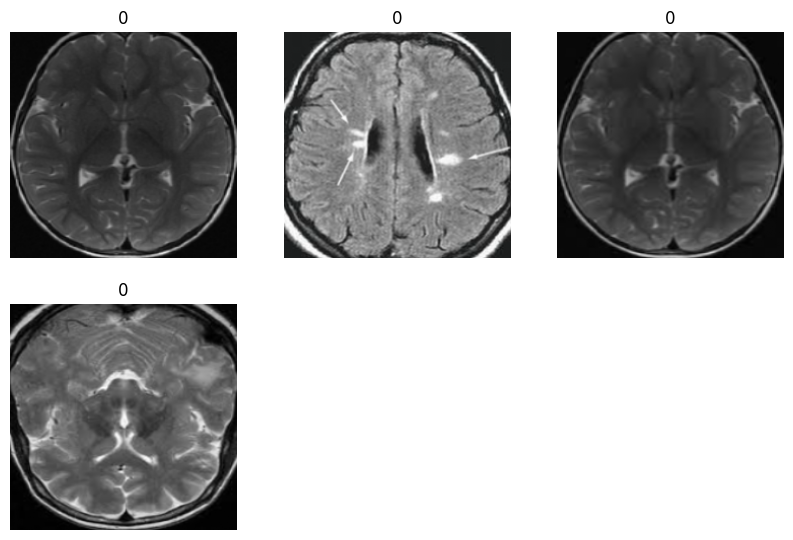

In [49]:
## Plot all wrong prediction

plt.figure(figsize=(10, 10))
for i in range(len(X_test_wrong)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test_wrong[i], cmap='gray')
    plt.title(str(y_test_wrong[i]))
    plt.axis("off")

plt.show()

## SHAP explanations

In [50]:
import shap
explainer = shap.DeepExplainer(model, data=X_test_prep)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [52]:
# ## Using SHAP to explain the model
# import shap
# # Create an explainer object
# for i in range(len(X_test_wrong)):
#     # Get a sample the wrong prediction
#     sample = X_test_wrong[i].reshape(1, 224, 224, 3)
#     # Get the shap values
#     shap_values = explainer.shap_values(sample)
#     # Plot the shap values
#     ## Add the original and probability of the wrong prediction
#     shap.image_plot(shap_values, sample, show=False)
#     plt.title('Original: ' + str(y_test_wrong[i]))
#     plt.show()

In [53]:
# import shap
# # Create an explainer object
# for i in [0,5,-4,-5,-7]:
#     # Get a sample the wrong prediction
#     sample = X_test_right[i].reshape(1, 224, 224, 3)
#     # Get the shap values
#     shap_values = explainer.shap_values(sample)
#     # Plot the shap values
#     ## Add the original and probability of the wrong prediction
#     shap.image_plot(shap_values, sample, show=False)
#     plt.title('Original: ' + str(y_test_right[i]))
#     plt.show()


## LIME Explanations

In [54]:
def prediction_function(images):
     return model.predict(images, verbose=False)

100%|██████████| 50/50 [00:04<00:00, 11.73it/s]


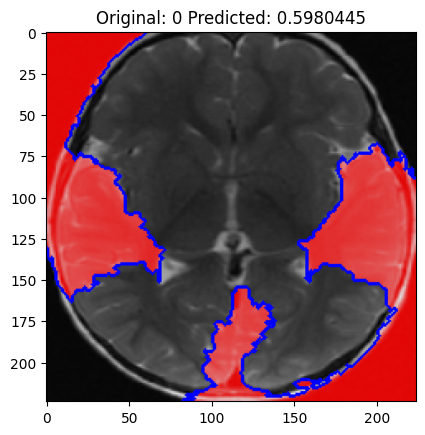

100%|██████████| 50/50 [00:04<00:00, 11.63it/s]


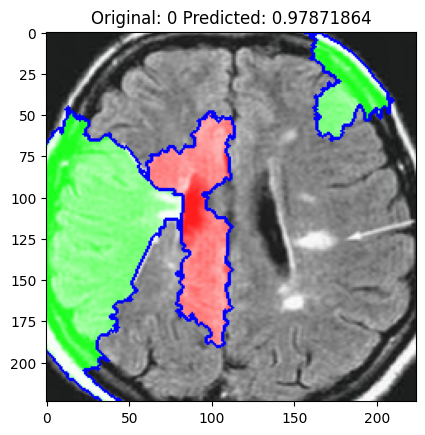

100%|██████████| 50/50 [00:04<00:00, 11.75it/s]


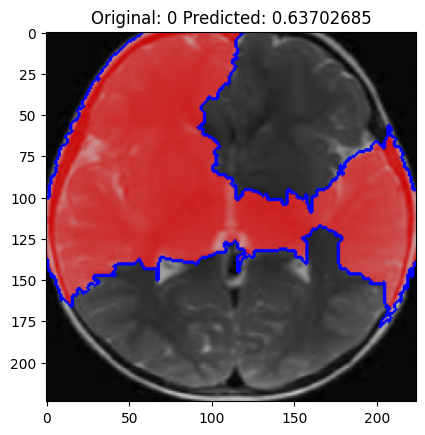

100%|██████████| 50/50 [00:04<00:00, 11.54it/s]


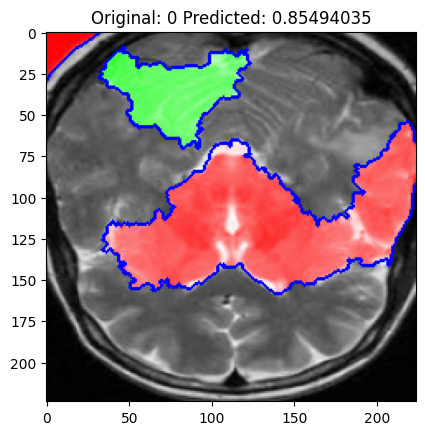

In [55]:
from skimage.segmentation import mark_boundaries
from lime import lime_image

for i in range(len(X_test_wrong)):
     explainer = lime_image.LimeImageExplainer(random_state=42, verbose=False)
     explanation = explainer.explain_instance(
          X_test_wrong[i],
          prediction_function,
          num_samples=50         
     )

     plt.title('Original: ' + str(y_test_wrong[i]) + ' Predicted: ' + str(model.predict(X_test_wrong[i].reshape(1, 224, 224, 3), verbose=False)[0][0]))
     plt.imshow(X_test_wrong[i])
     image, mask = explanation.get_image_and_mask(
          model.predict(
               X_test_wrong[0].reshape(1, 224, 224, 3), verbose=False
          ).argmax(axis=1)[0],
          positive_only=False,
          negative_only=False,
          hide_rest=False
     )
     plt.imshow(mark_boundaries(image, mask, color=(0, 0, 1), mode='thick'))
     plt.show()

100%|██████████| 50/50 [00:05<00:00,  9.99it/s]


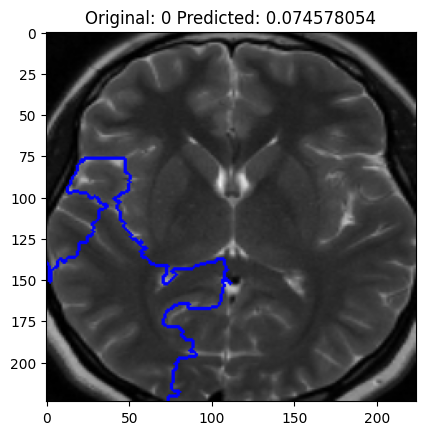

100%|██████████| 50/50 [00:04<00:00, 11.75it/s]


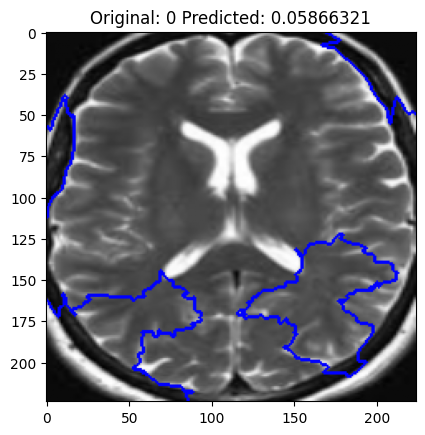

100%|██████████| 50/50 [00:04<00:00, 12.02it/s]


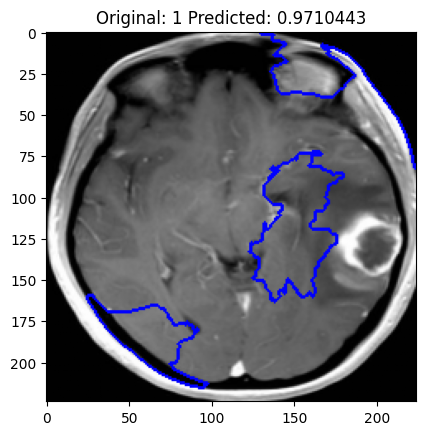

100%|██████████| 50/50 [00:04<00:00, 11.69it/s]


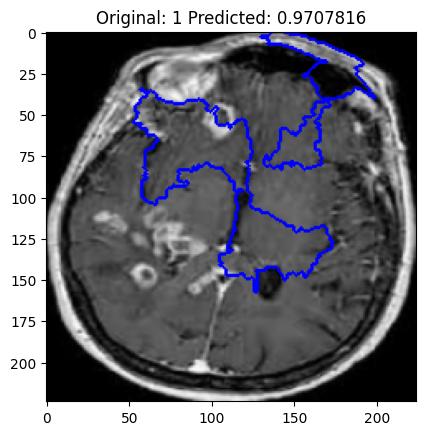

100%|██████████| 50/50 [00:04<00:00, 12.03it/s]


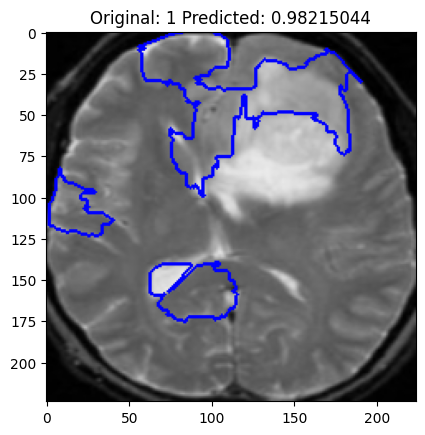

In [57]:
## Write the above code for X_test_right
for i in [0,5,-4,-5,-7]:
    explainer = lime_image.LimeImageExplainer(random_state=42, verbose=False)
    explanation = explainer.explain_instance(
        X_test_right[i],
        prediction_function,
        num_samples=50         
    )

    plt.title('Original: ' + str(y_test_right[i]) + ' Predicted: ' + str(model.predict(X_test_right[i].reshape(1, 224, 224, 3), verbose=False)[0][0]))
    plt.imshow(X_test_right[i])
    image, mask = explanation.get_image_and_mask(
        model.predict(
            X_test_right[0].reshape(1, 224, 224, 3), verbose=False
        ).argmax(axis=1)[0],
        positive_only=True,
        negative_only=False,
        hide_rest=False
    )
    plt.imshow(mark_boundaries(image, mask, color=(0, 0, 1), mode='thick'))
    plt.show()
